## Hackathon - Building a Movie Recommendation System


1. Initial Data Preparation


In [ ]:
import pandas as pd

movies_df = pd.read_csv('/content/movies.csv')
ratings_df = pd.read_csv('/content/ratings.csv')

# Group user ratings based on movieId
grouped_ratings = ratings_df.groupby('movieId').agg({'rating': ['count', 'mean']})
grouped_ratings.columns = ['rating_count', 'rating_mean']

# Merge with movies data
merged_df = pd.merge(movies_df, grouped_ratings, on='movieId')

# Filter movies with more than 50 user ratings
popular_movies_df = merged_df[merged_df['rating_count'] > 50]

In [ ]:
movies_df.shape

(9742, 3)

In [ ]:
ratings_df.shape

(100836, 4)

In [ ]:
ratings_df.userId.nunique()

610

In [ ]:
print(popular_movies_df.loc[popular_movies_df['rating_count'].idxmax()]['title'])

Forrest Gump (1994)


In [ ]:
tags_df = pd.read_csv('/content/tags.csv')

matrix_id = movies_df[movies_df['title'] == 'Matrix, The (1999)']['movieId'].iloc[0]

# Get all tags for the movie
matrix_tags = tags_df[tags_df['movieId'] == matrix_id]['tag']

print(f"Tags for The Matrix (1999): {', '.join(matrix_tags)}")

Tags for The Matrix (1999): martial arts, sci-fi, alternate universe, philosophy, post apocalyptic


In [ ]:
terminator_id = movies_df[movies_df['title'] == 'Terminator 2: Judgment Day (1991)']['movieId'].iloc[0]

# Get the average rating for the movie
terminator_rating = merged_df[merged_df['movieId'] == terminator_id]['rating_mean'].iloc[0]

print(f"Average rating for Terminator 2: Judgment Day (1991): {terminator_rating}")


Average rating for Terminator 2: Judgment Day (1991): 3.970982142857143


count    218.000000
mean       4.272936
std        0.861384
min        0.500000
25%        4.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: rating, dtype: float64


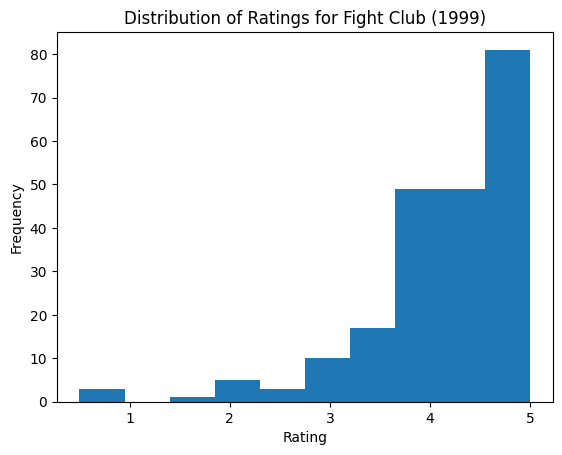

In [ ]:
fight_club_id = movies_df[movies_df['title'] == 'Fight Club (1999)']['movieId'].iloc[0]

# Get the ratings for the movie
fight_club_ratings = ratings_df[ratings_df['movieId'] == fight_club_id]['rating']

print(fight_club_ratings.describe())

import matplotlib.pyplot as plt
plt.hist(fight_club_ratings, bins=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings for Fight Club (1999)")
plt.show()


2. Answering Questions


a. Most Popular Movie Based on Average User Ratings


In [ ]:
most_popular_movie = popular_movies_df.loc[popular_movies_df['rating_mean'].idxmax()]
most_popular_movie_name = most_popular_movie['title']

print(f"Most popular movie based on average user ratings: {most_popular_movie_name}")

Most popular movie based on average user ratings: Shawshank Redemption, The (1994)


b. Top 5 Movies Based on Number of User Ratings


In [ ]:
top_5_movies = popular_movies_df.nlargest(5, 'rating_count')
top_5_movie_titles = top_5_movies['title'].tolist()

print(f"Top 5 movies based on number of user ratings: {top_5_movie_titles}")

Top 5 movies based on number of user ratings: ['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)']


c. Third Most Popular Sci-Fi Movie Based on Number of User Ratings


In [ ]:
sci_fi_movies_df = popular_movies_df[popular_movies_df['genres'].str.contains('Sci-Fi')]

# Third most popular Sci-Fi movie
third_most_popular_sci_fi = sci_fi_movies_df.nlargest(3, 'rating_count').iloc[2]
third_most_popular_sci_fi_title = third_most_popular_sci_fi['title']

print(f"Third most popular Sci-Fi movie based on number of user ratings: {third_most_popular_sci_fi_title}")

Third most popular Sci-Fi movie based on number of user ratings: Jurassic Park (1993)


3. Scraping IMDb Ratings


In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

titles = []
years = []
time = []
imdb_ratings = []
metascores = []
votes = []
us_gross = []

headers = {'Accept-Language': 'en-US, en;q=0.5'}

pages = np.arange(1, 1001, 50)

for page in pages:
    url = f'https://www.imdb.com/search/title/?groups=top_1000&start={page}&ref_=adv_nxt'
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    movie_divs = soup.find_all('div', class_='lister-item mode-advanced')

    sleep(randint(2,10))

    for container in movie_divs:
        name = container.h3.a.text
        titles.append(name)

        year = container.h3.find('span', class_='lister-item-year').text
        years.append(year)

        runtime = container.find('span', class_='runtime').text if container.find('span', class_='runtime') else '-'
        time.append(runtime)

        imdb = container.strong.text
        imdb_ratings.append(float(imdb) if imdb != '-' else np.nan)

        metascore = container.find('span', class_='metascore').text if container.find('span', class_='metascore') else '-'
        metascores.append(metascore)

        nv = container.find_all('span', attrs={'name':'nv'})
        vote = nv[0].text if len(nv) > 0 else '-'
        votes.append(vote)
        gross = nv[1].text if len(nv) > 1 else '-'
        us_gross.append(gross)

        imdb_id = container.h3.a['href'].split('/')[2] if container.h3.a else '-'
        imdb_ids.append(imdb_id)

In [ ]:
movies = pd.DataFrame({
    'movie': titles,
    'year': years,
    'time_minute': time,
    'imdb_rating': imdb_ratings,
    'metascore': metascores,
    'vote': votes,
    'gross_earning': us_gross
})

movies['year'] = movies['year'].astype(str)
movies['time_minute'] = movies['time_minute'].astype(str)
movies['imdb_rating'] = pd.to_numeric(movies['imdb_rating'], errors='coerce')
movies['metascore'] = movies['metascore'].astype(str)
movies['vote'] = movies['vote'].astype(str)
movies['gross_earning'] = movies['gross_earning'].astype(str)

print(movies.head())
print(movies.dtypes)

Empty DataFrame
Columns: [movie, year, time_minute, imdb_rating, metascore, vote, gross_earning]
Index: []
movie            float64
year              object
time_minute       object
imdb_rating      float64
metascore         object
vote              object
gross_earning     object
dtype: object


In [ ]:
movies.to_csv('popular_movies_with_imdb_ratings.csv', index=False)

In [ ]:
import pandas as pd

popular_movies_df = pd.read_csv('/content/popular_movies_with_imdb_ratings.csv')

print(popular_movies_df.describe(include='all'))
print(popular_movies_df.head())

print(popular_movies_df['imdb_rating'].isna().sum())

       movie year time_minute imdb_rating metascore vote gross_earning
count      0    0           0           0         0    0             0
unique     0    0           0           0         0    0             0
top      NaN  NaN         NaN         NaN       NaN  NaN           NaN
freq     NaN  NaN         NaN         NaN       NaN  NaN           NaN
Empty DataFrame
Columns: [movie, year, time_minute, imdb_rating, metascore, vote, gross_earning]
Index: []
0
